# Regression Analysis with Linear Regression

In this analysis, we focus on regression analysis, particularly preprocessing, exploratory data analysis (EDA), and a raw estimate of the model for linear regression.

## Steps:

1. **Importing:** 
   - Import the necessary libraries and dataset.
   
2. **Missing Values Check:** 
   - Identify and handle missing values appropriately.
   
3. **Categorical EDA:** 
    - Explore categorical variables through visualizations like  frequency tables to understand their distribution and relationship with the target variable.

4. **Hypothesis Testing:** 
   - Perform hypothesis testing (Kruskal-Wallis test), to understand relationships between variables.

5. **Manual Encoding Insights:** 
   - Examine the categorical variables and encode them manually, if necessary, based on insights gained from EDA.

6. **Numerical EDA:** 
   - Analyze numerical variables using techniques such as histograms and correlation matrices to identify patterns, outliers, and relationships with the target variable.
   
7. **Pipeline Building:** 
   - Construct a data processing pipeline to streamline the preprocessing steps and model building process.
   
8. **Sample Modeling:** 
   - Build a raw estimate model for linear regression using the preprocessed data.



In [193]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [194]:
data=pl.read_csv("CarPrice_Assignment.csv")
data.head()

car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
i64,i64,str,str,str,str,str,str,str,f64,f64,f64,f64,i64,str,str,i64,str,f64,f64,f64,i64,i64,i64,i64,f64
1,3,"""alfa-romero giulia""","""gas""","""std""","""two""","""convertible""","""rwd""","""front""",88.6,168.8,64.1,48.8,2548,"""dohc""","""four""",130,"""mpfi""",3.47,2.68,9.0,111,5000,21,27,13495.0
2,3,"""alfa-romero stelvio""","""gas""","""std""","""two""","""convertible""","""rwd""","""front""",88.6,168.8,64.1,48.8,2548,"""dohc""","""four""",130,"""mpfi""",3.47,2.68,9.0,111,5000,21,27,16500.0
3,1,"""alfa-romero Quadrifoglio""","""gas""","""std""","""two""","""hatchback""","""rwd""","""front""",94.5,171.2,65.5,52.4,2823,"""ohcv""","""six""",152,"""mpfi""",2.68,3.47,9.0,154,5000,19,26,16500.0
4,2,"""audi 100 ls""","""gas""","""std""","""four""","""sedan""","""fwd""","""front""",99.8,176.6,66.2,54.3,2337,"""ohc""","""four""",109,"""mpfi""",3.19,3.4,10.0,102,5500,24,30,13950.0
5,2,"""audi 100ls""","""gas""","""std""","""four""","""sedan""","""4wd""","""front""",99.4,176.6,66.4,54.3,2824,"""ohc""","""five""",136,"""mpfi""",3.19,3.4,8.0,115,5500,18,22,17450.0


Check for Linearity between independent variables and dependent variable

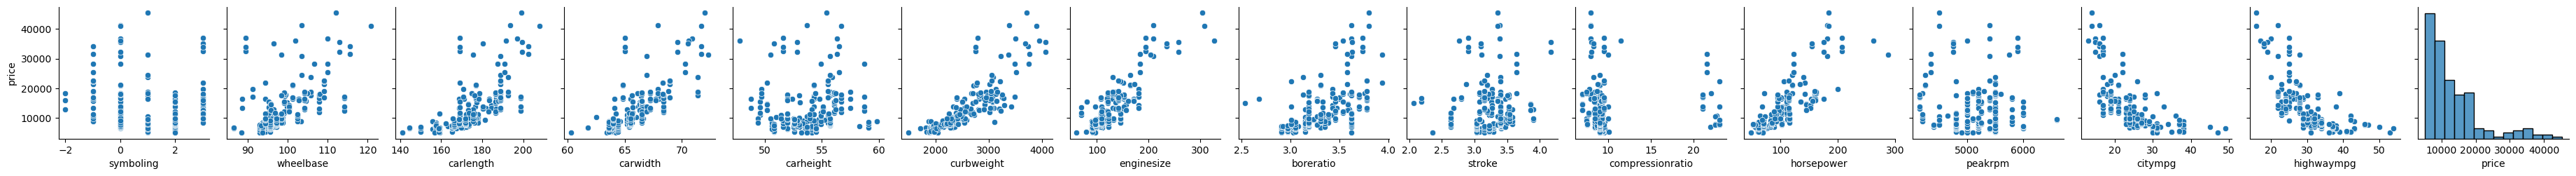

In [195]:
sns.pairplot(data.drop("car_ID").to_pandas(),y_vars=["price"])
plt.show()

Dependent variable is much skewed

Missing Values

In [196]:
data.null_count()

car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


No missing

In [197]:
data.shape,data.n_unique()

((205, 26), 205)

In [198]:
cat_cols=[col for col in data.columns if data[col].dtype== pl.String]
num_cols=[col for col in data.drop("car_ID","price").columns if data[col].dtype!= pl.String]

# Splitting data (avoiding data leakages)

In [199]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop("price"),data[["car_ID","price"]],test_size=0.2,random_state=20)
train_data=X_train.join(y_train,on="car_ID")
test_data=X_test.join(y_test,on="car_ID")
train_data.shape,test_data.shape

((164, 26), (41, 26))

## extracting brand names and performing target mean encoding based

In [200]:
l=data["CarName"].str.split(" ")
brands=[]
for i in l:
    brands.append(i[0])
data=data.with_columns(pl.Series(brands).alias("CarName"))
data=data.with_columns(data["CarName"].str.replace("porsche","porcshce"))

In [201]:
train_data=train_data.drop("CarName").join(data[["car_ID","CarName"]],on="car_ID")
test_data=test_data.drop("CarName").join(data[["car_ID","CarName"]],on="car_ID")

In [202]:
encoder_list=train_data[['CarName','price']].group_by(["CarName"]).agg(pl.median("price")).sort(by="price")
encoder_list

CarName,price
str,f64
"""maxda""",5645.0
"""chevrolet""",5723.0
"""dodge""",7150.5
"""plymouth""",7575.0
"""honda""",7595.0
…,…
"""volvo""",18685.0
"""bmw""",24565.0
"""porcshce""",33278.0


In [203]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=4,encode='ordinal',strategy='quantile') # from power bi

discretizer.fit(encoder_list[['price']])
bins = discretizer.transform(encoder_list[['price']])

# Print bin labels (array format)
encoder_list=encoder_list.hstack(pl.DataFrame(bins,schema=["carclass"]))
encoder_list

CarName,price,carclass
str,f64,f64
"""maxda""",5645.0,0.0
"""chevrolet""",5723.0,0.0
"""dodge""",7150.5,0.0
"""plymouth""",7575.0,0.0
"""honda""",7595.0,0.0
…,…,…
"""volvo""",18685.0,3.0
"""bmw""",24565.0,3.0
"""porcshce""",33278.0,3.0


In [204]:
def mean_encoder(x):
    if encoder_list.filter(encoder_list['CarName']==x).is_empty():
        return encoder_list['price'].median()
    return encoder_list.filter(encoder_list['CarName']==x)['price'][0]
def car_class(x):
    if encoder_list.filter(encoder_list['CarName']==x).is_empty():
        return encoder_list['carclass'].mean()
    return encoder_list.filter(encoder_list['CarName']==x)["carclass"][0]
    
train_data=train_data.with_columns(train_data['CarName'].map_elements(lambda x:car_class(x),return_dtype=pl.Float64).alias("carclass"))
test_data=test_data.with_columns(test_data['CarName'].map_elements(lambda x:car_class(x),return_dtype=pl.Float64).alias("carclass"))
train_data=train_data.with_columns(train_data['CarName'].map_elements(lambda x:mean_encoder(x),return_dtype=pl.Float64).alias("brandavg")).drop("CarName")
test_data=test_data.with_columns(test_data['CarName'].map_elements(lambda x:mean_encoder(x),return_dtype=pl.Float64).alias("brandavg")).drop("CarName")

In [205]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

# Categorical EDA

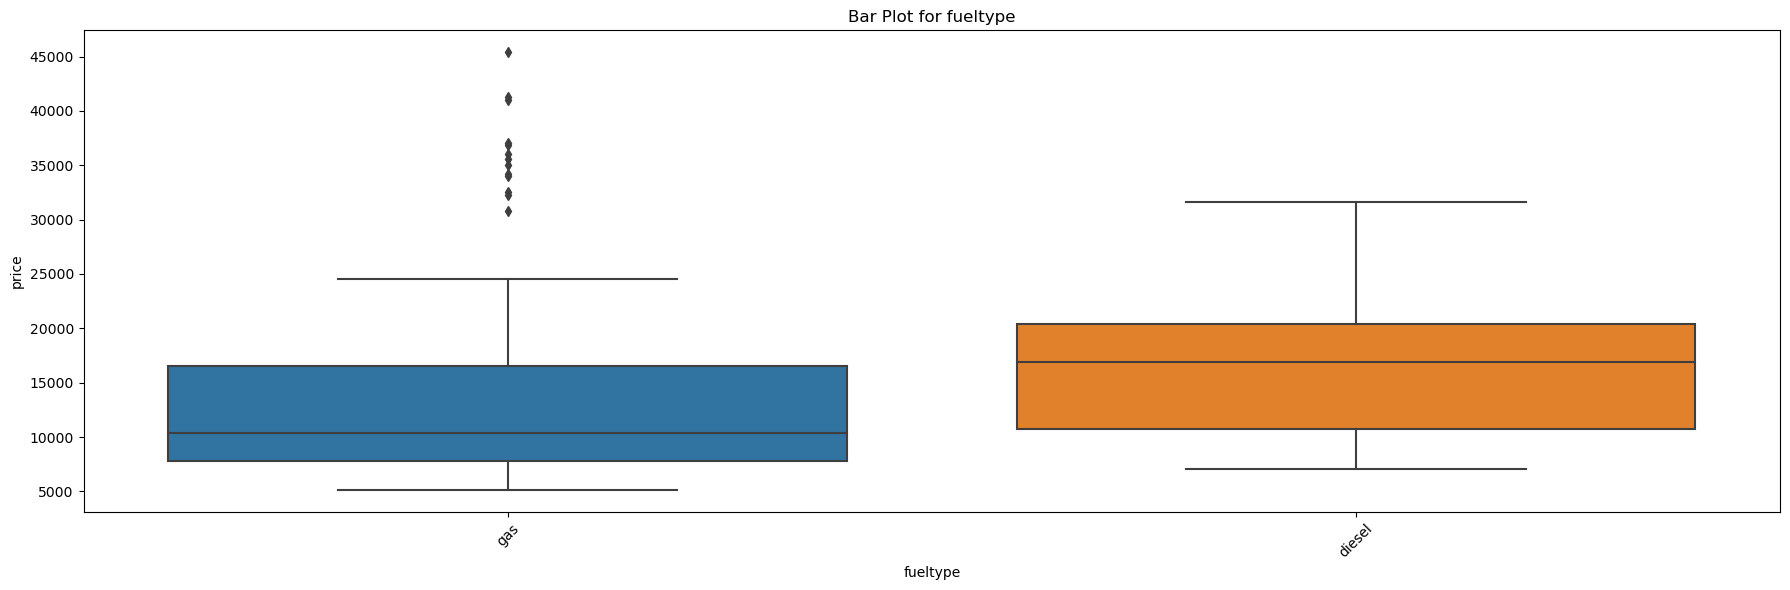

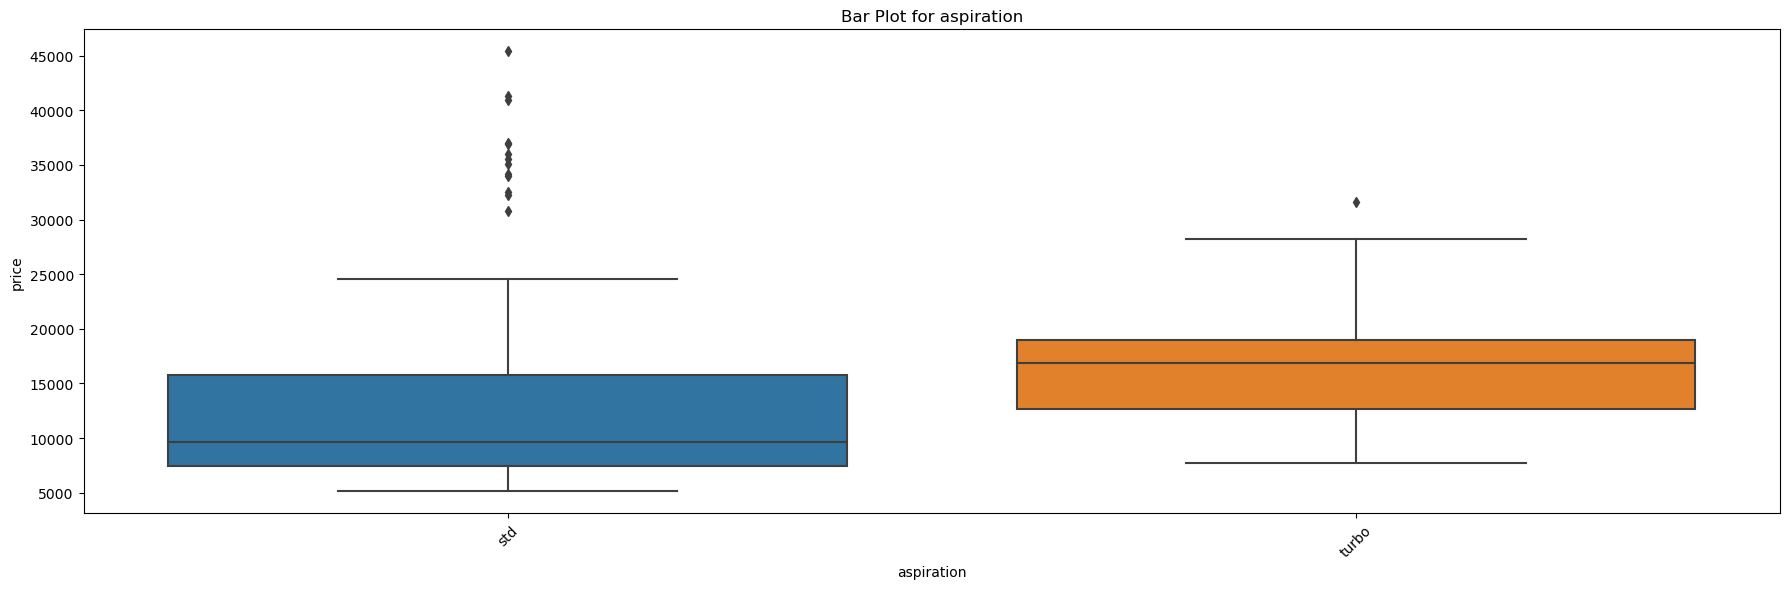

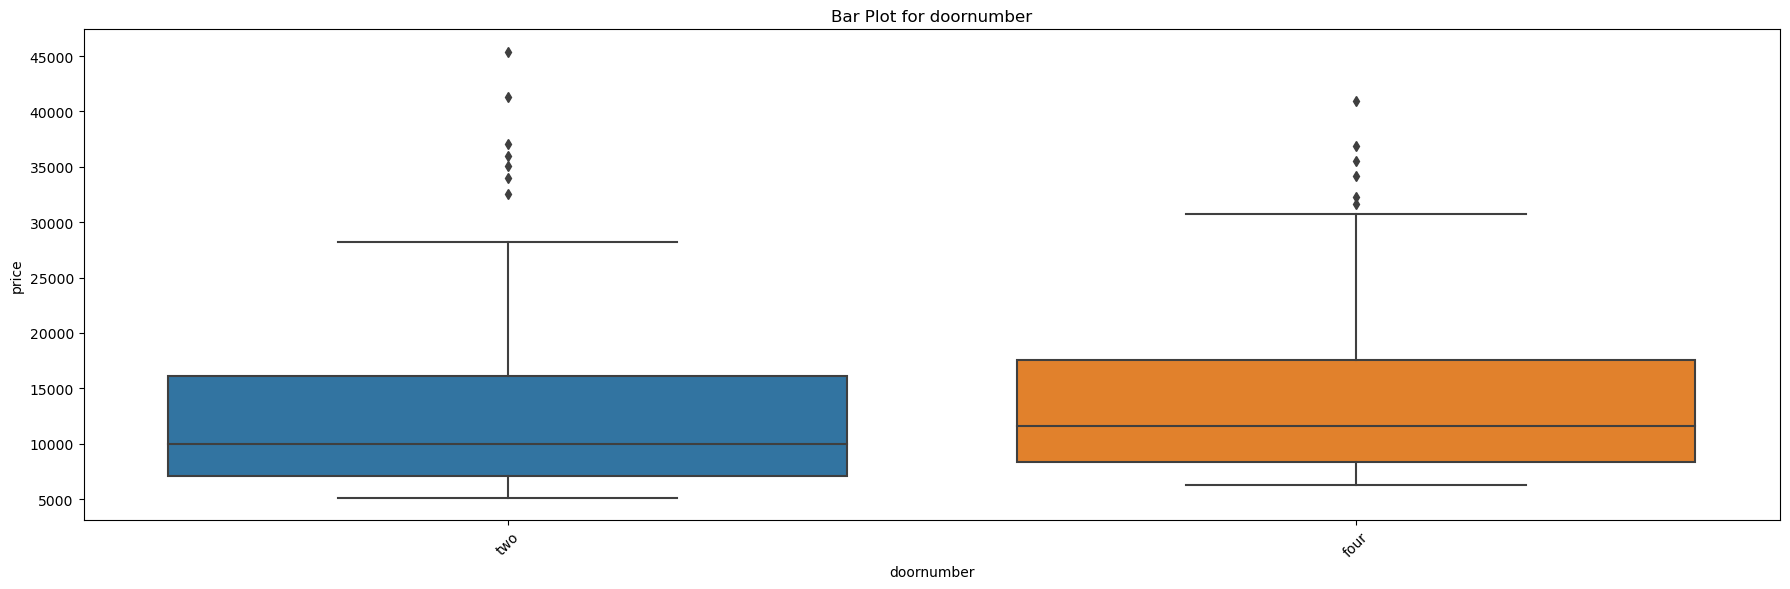

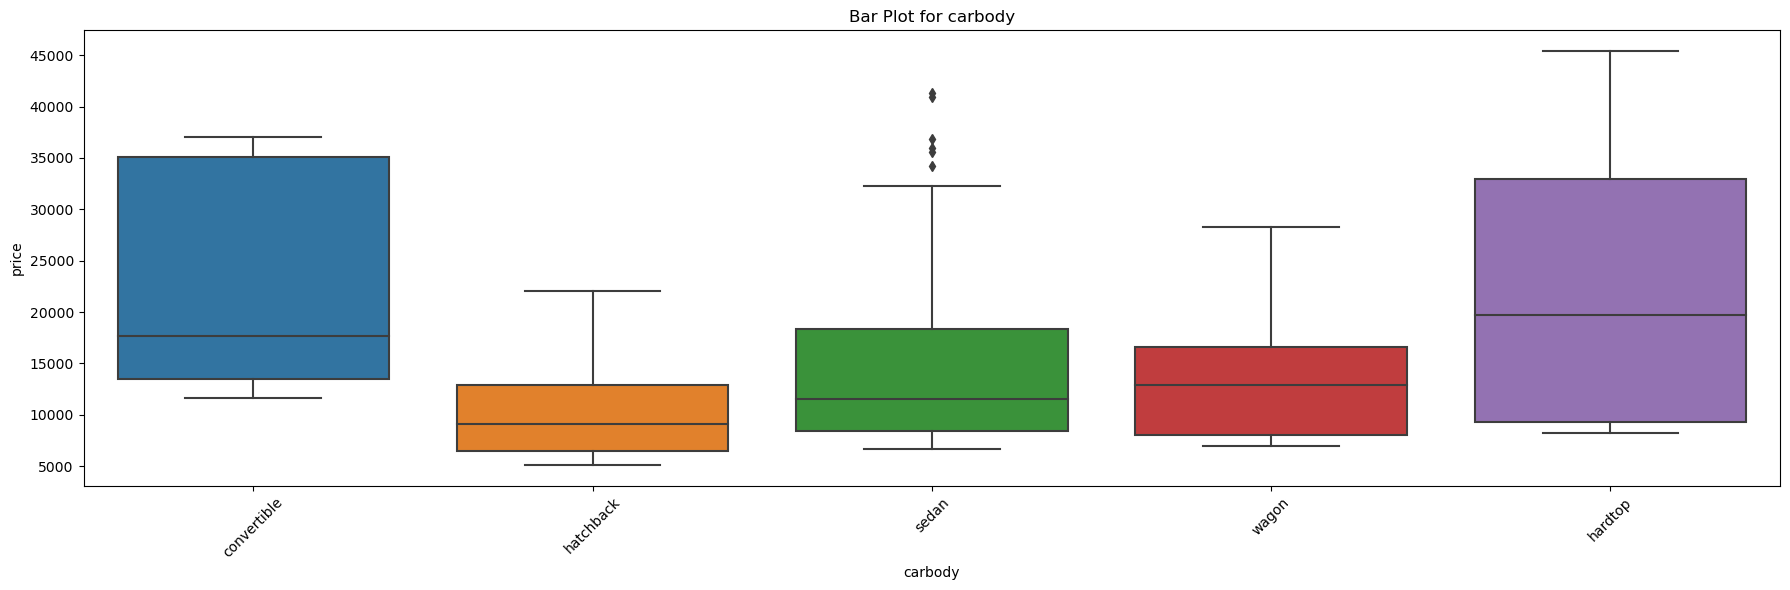

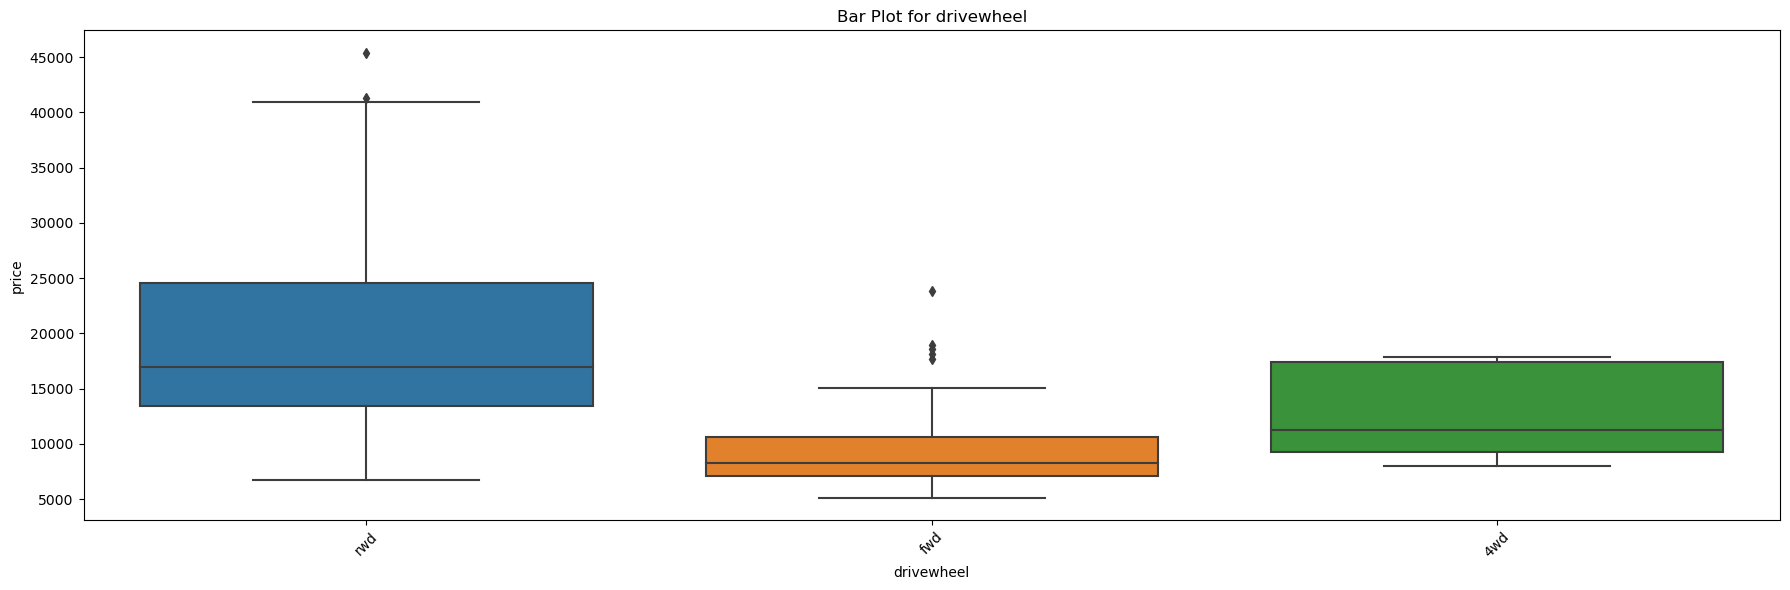

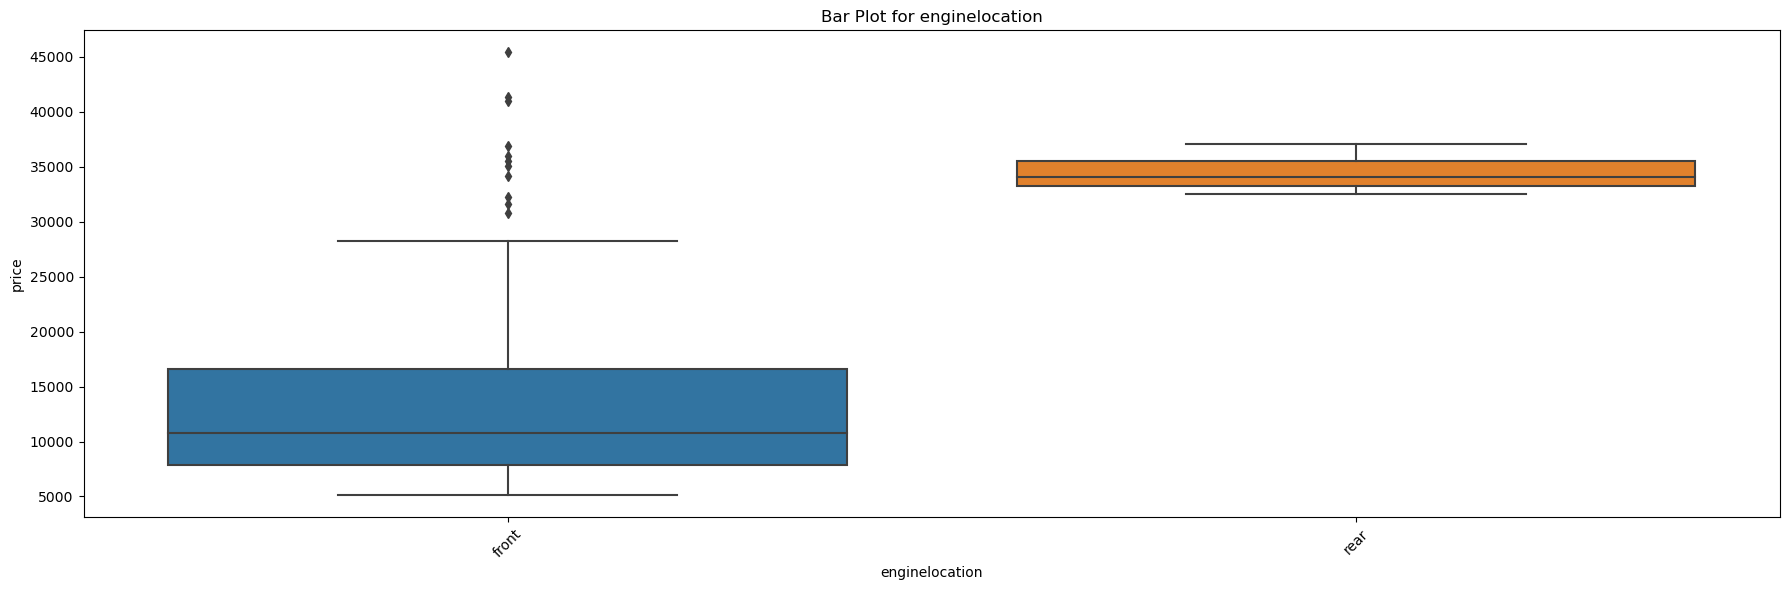

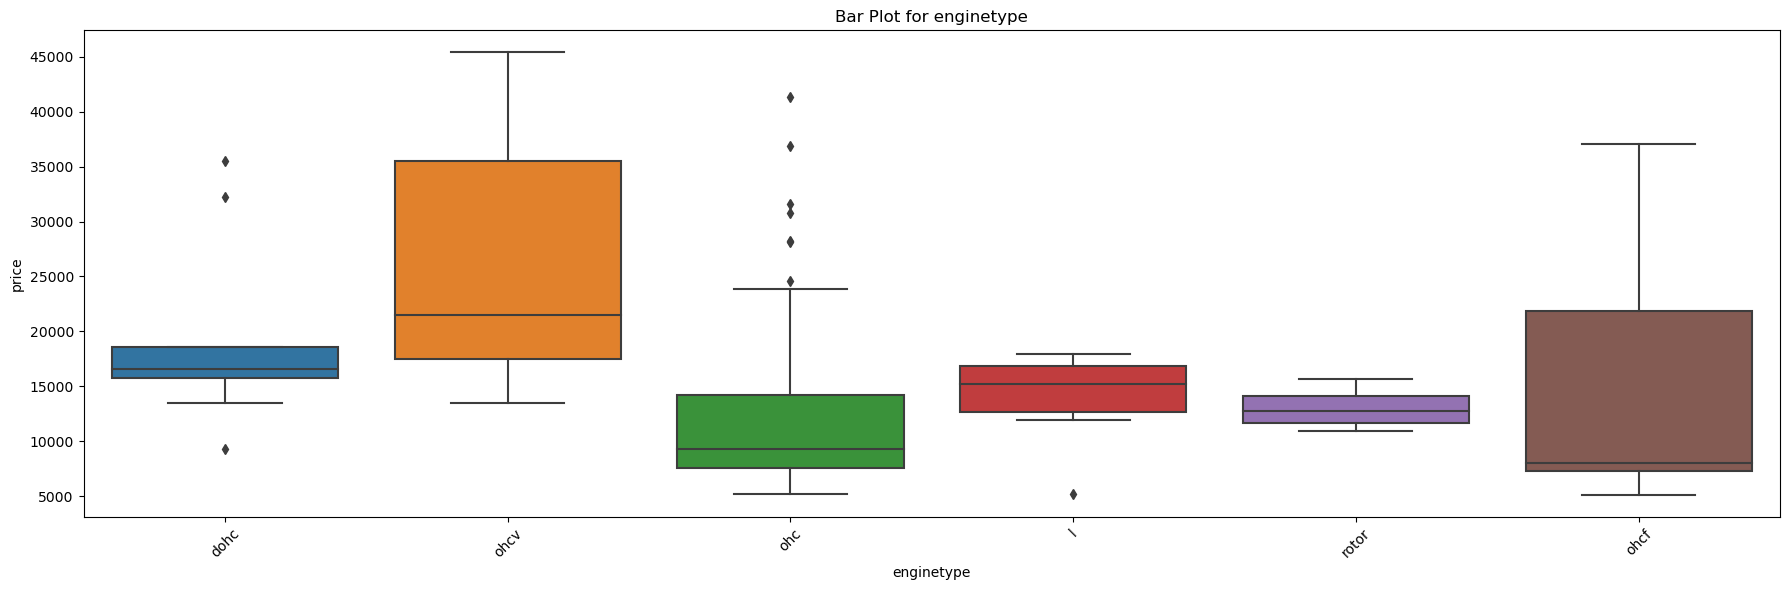

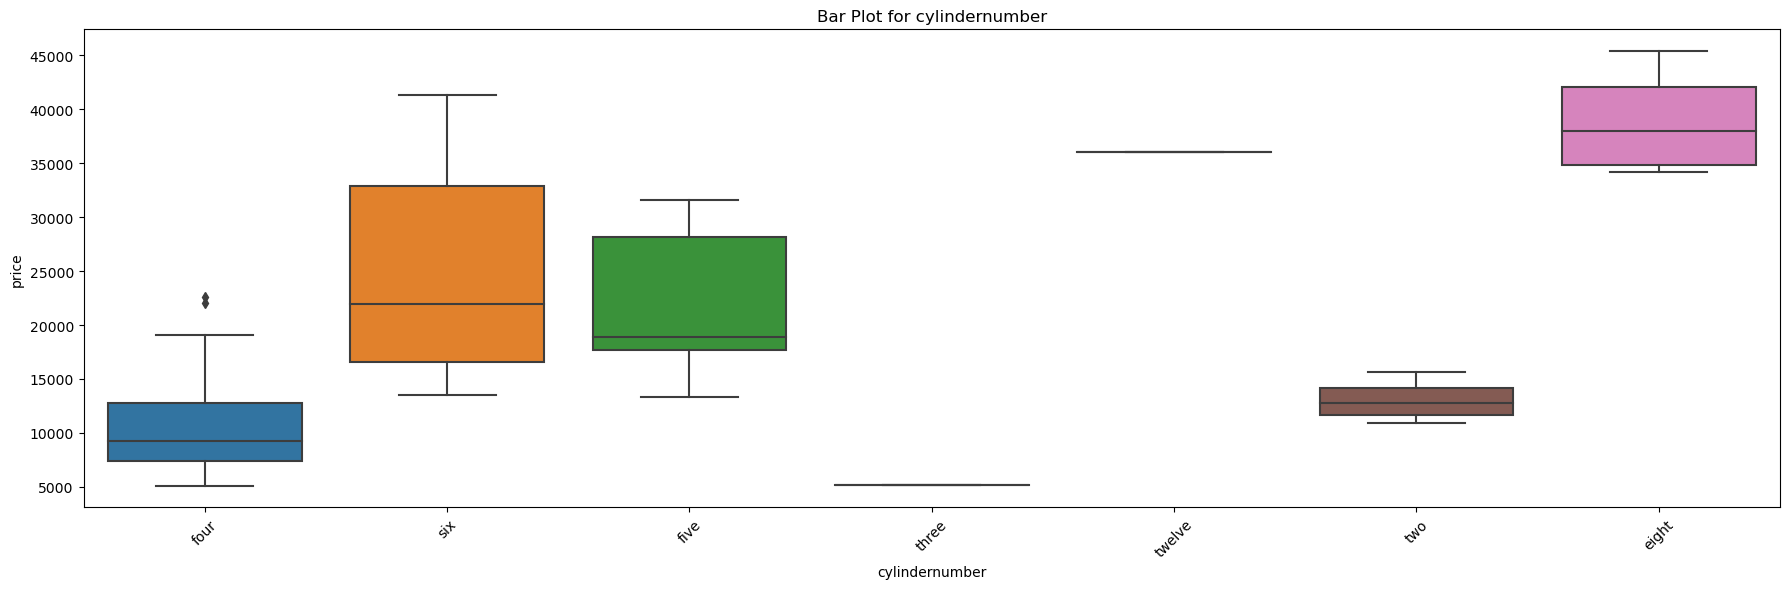

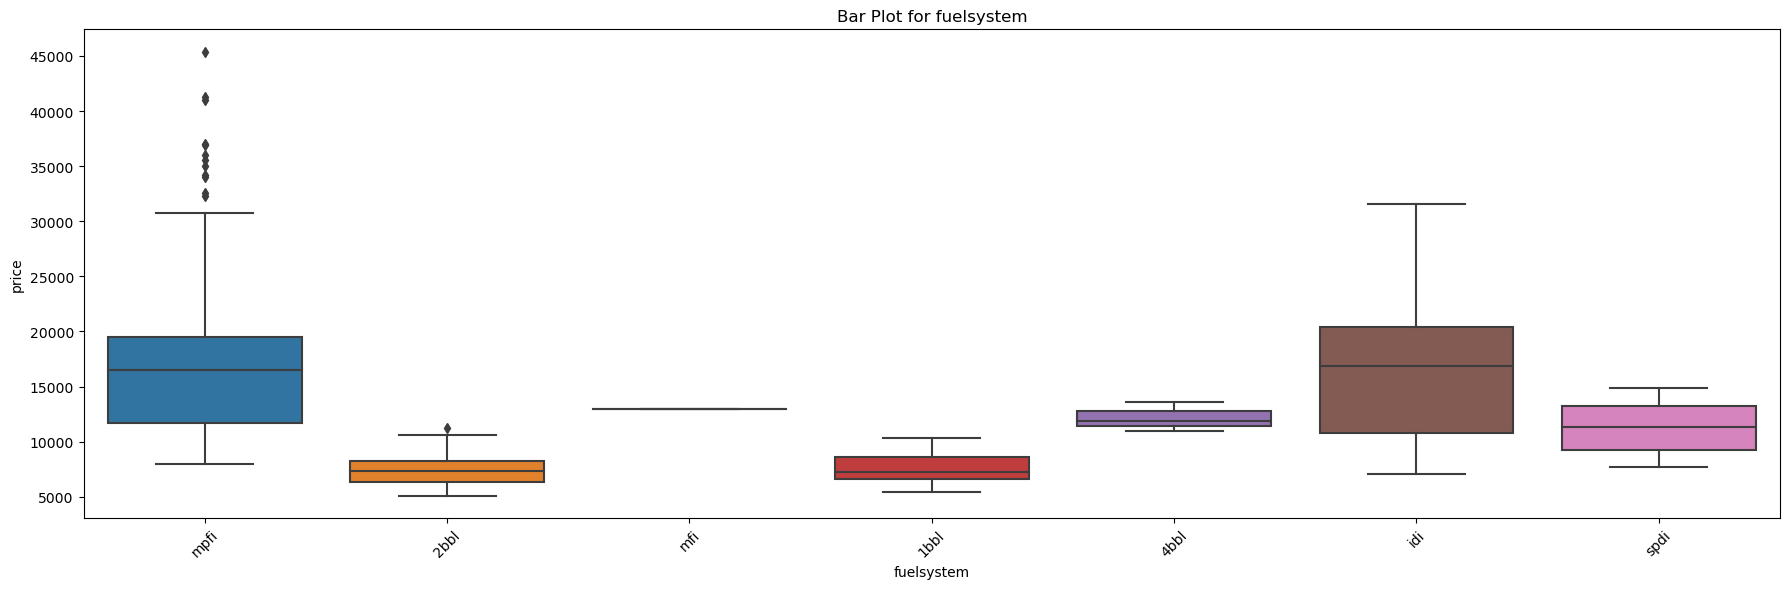

In [206]:
categorical_box_plot(train_data.to_pandas(),cat_cols,"price")

Some outliers present feature wise, they can be dropped or investigated in error analysis

Performing Kruskal-Walli test (rank based) instead of ANOVA as data not following normal distribution

In [183]:
perform_non_normal_kruskal_hypothesis(train_data,cat_cols,"price",alpha=0.05)

Kruskal-Wallis H-statistic: 4.112462382213712 P-value: 0.04256834168184948
There is a significant difference in price between different fueltype categories.

Kruskal-Wallis H-statistic: 15.986773343064142 P-value: 6.37865737204927e-05
There is a significant difference in price between different aspiration categories.

Kruskal-Wallis H-statistic: 3.2062962748417743 P-value: 0.07335535849449258
There is no significant difference in price between different doornumber categories.

Kruskal-Wallis H-statistic: 20.912602187292062 P-value: 0.00032955700937504996
There is a significant difference in price between different carbody categories.

Kruskal-Wallis H-statistic: 75.3155609063669 P-value: 4.4201168293296795e-17
There is a significant difference in price between different drivewheel categories.

Kruskal-Wallis H-statistic: 7.45440793825647 P-value: 0.006328128980739591
There is a significant difference in price between different enginelocation categories.

Kruskal-Wallis H-statistic: 30.

Dropping dorrnumber,fueltype

In [184]:
train_data=train_data.drop("doornumber")
test_data=test_data.drop("doornumber")
cat_cols.remove("doornumber")

train_data=train_data.drop("fueltype")  # near to 0.05
test_data=test_data.drop("fueltype")
cat_cols.remove("fueltype")

In [185]:
for i in cat_cols:
    print(train_data[i].value_counts())

shape: (2, 2)
┌────────────┬───────┐
│ aspiration ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ turbo      ┆ 31    │
│ std        ┆ 133   │
└────────────┴───────┘
shape: (5, 2)
┌─────────────┬───────┐
│ carbody     ┆ count │
│ ---         ┆ ---   │
│ str         ┆ u32   │
╞═════════════╪═══════╡
│ convertible ┆ 5     │
│ wagon       ┆ 20    │
│ hatchback   ┆ 59    │
│ hardtop     ┆ 8     │
│ sedan       ┆ 72    │
└─────────────┴───────┘
shape: (3, 2)
┌────────────┬───────┐
│ drivewheel ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ fwd        ┆ 94    │
│ 4wd        ┆ 5     │
│ rwd        ┆ 65    │
└────────────┴───────┘
shape: (2, 2)
┌────────────────┬───────┐
│ enginelocation ┆ count │
│ ---            ┆ ---   │
│ str            ┆ u32   │
╞════════════════╪═══════╡
│ front          ┆ 161   │
│ rear           ┆ 3     │
└────────────────┴───────┘
shape: (6, 2)
┌────────────┬───────┐
│ enginetype ┆ count │
│ ---        

Many columns with less value counts

# Manual encoding from insights (some insights are from powerbi reports)

In [186]:
train_data= train_data.filter(~(train_data['enginetype']=='dohcv')) # only one observation mixing with near values
train_data= train_data.with_columns(train_data['enginelocation'].is_in(["rear"]).cast(pl.Int64))
train_data=train_data.with_columns(train_data["drivewheel"].str.replace_many(["4wd"],["fwd"]))
train_data=train_data.with_columns(train_data["drivewheel"].is_in(["rwd"]).cast(pl.Int64))
#imputing average prices from power bi
train_data=train_data.with_columns(train_data["cylindernumber"].str.replace_many(["three","four","two","five","six","eight","twelve"],["5","9","13","19","21","35",'36']).cast(pl.Int64))
train_data=train_data.with_columns(train_data["enginetype"].str.replace("dohcv","ohcv"))

test_data= test_data.with_columns(test_data['enginelocation'].is_in(["rear"]).cast(pl.Int64))
test_data=test_data.with_columns(test_data["drivewheel"].str.replace_many(["4wd"],["fwd"]))
test_data=test_data.with_columns(test_data["drivewheel"].is_in(["rwd"]).cast(pl.Int64))
test_data=test_data.with_columns(test_data["cylindernumber"].str.replace_many(["three","four","two","five","six","eight","twelve"],["5","9","13","19","21","35",'36']).cast(pl.Int64))
test_data=test_data.with_columns(test_data["enginetype"].str.replace("dohcv","ohcv"))

cat_cols.remove("drivewheel")
cat_cols.remove("cylindernumber")
num_cols.append("drivewheel")
num_cols.append("cylindernumber")

# Numerical eda

In [187]:
train_data[num_cols]

symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,carclass,brandavg,drivewheel,cylindernumber
i64,f64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64
3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,2.0,14997.5,1,9
1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,2.0,14997.5,1,21
2,99.8,176.6,66.2,54.3,2337,109,3.19,3.4,10.0,102,5500,24,30,3.0,17784.5835,0,9
2,99.4,176.6,66.4,54.3,2824,136,3.19,3.4,8.0,115,5500,18,22,3.0,17784.5835,0,19
1,105.8,192.7,71.4,55.7,2844,136,3.19,3.4,8.5,110,5500,19,25,3.0,17784.5835,0,19
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-1,104.3,188.8,67.2,57.5,3157,130,3.62,3.15,7.5,162,5100,17,22,3.0,18685.0,1,9
-1,109.1,188.8,68.8,55.5,3049,141,3.78,3.15,8.7,160,5300,19,25,3.0,18685.0,1,9
-1,109.1,188.8,68.9,55.5,3012,173,3.58,2.87,8.8,134,5500,18,23,3.0,18685.0,1,21


Univariate Analysis

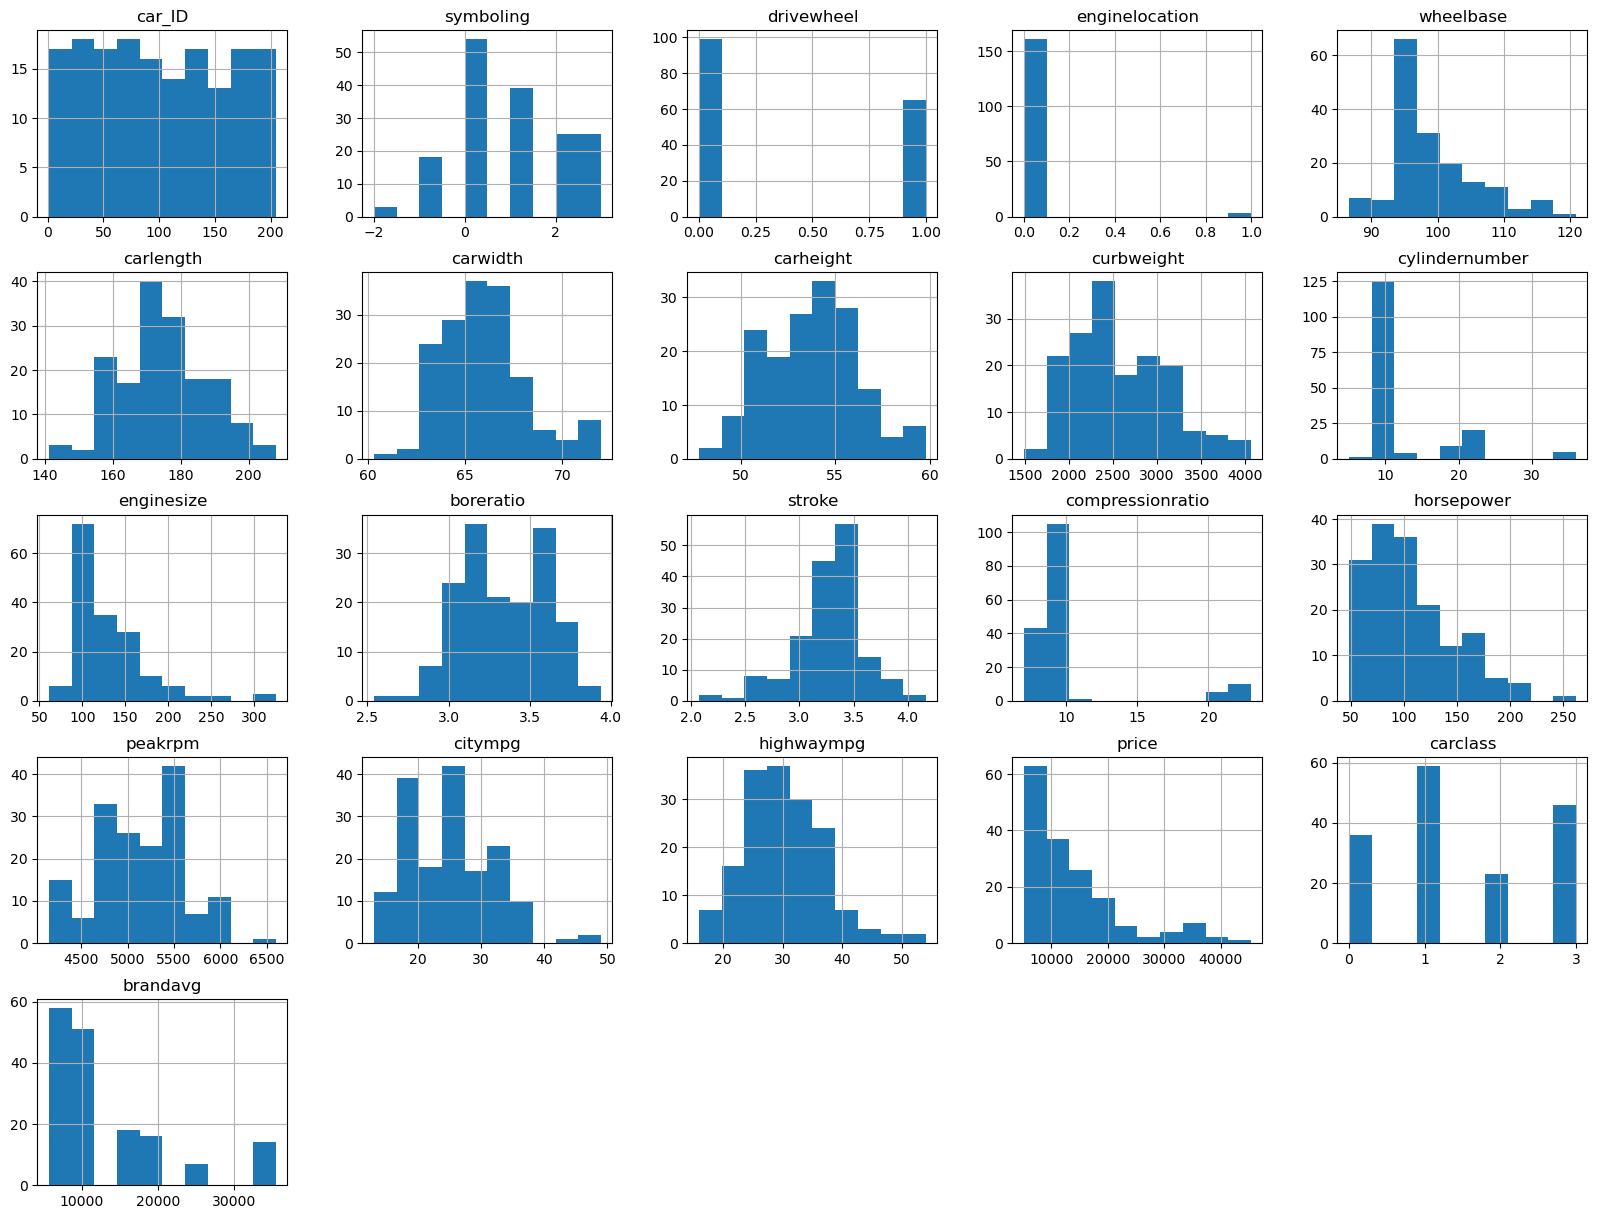

In [188]:
train_data.to_pandas().hist(bins=10,figsize=(20,15))
plt.show()

# Most features are roughly Normal, some are Right skewed including the dependent variable "Price"

Bivariate Analysis

<Axes: >

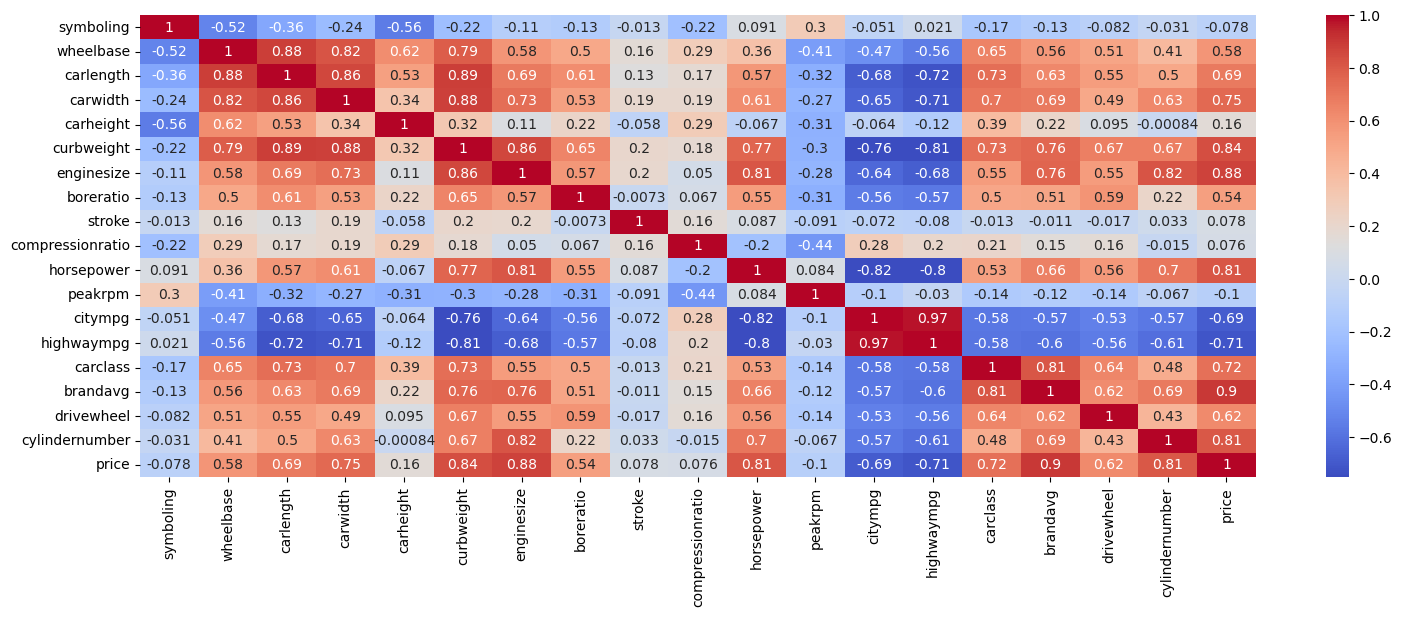

In [189]:
plt.figure(figsize=(18,6))
sns.heatmap(train_data[num_cols+["price"]].to_pandas().corr(),annot=True,cmap="coolwarm",robust=True)

# Lot of Multi collinear features exists

Will deal with these multi collinear features based on modeling results

In [190]:
train_data.write_csv("../Day2_naive_modeling/train_preprocessed.csv")
test_data.write_csv("../Day2_naive_modeling/test_preprocessed.csv")
train_data.write_csv("../Day3_featureEngineering/train_preprocessed.csv")
test_data.write_csv("../Day3_featureEngineering/test_preprocessed.csv")

# Building pipeline

In [191]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler

cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")
pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("lr",LinearRegression())
])
pipe

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                min_frequency=9),
                                                  ['aspiration', 'carbody',
                                                   'enginetype',
                                                   'fuelsystem']),
                                                 ('num', StandardScaler(),
                                                  ['symboling', 'drivewheel',
                                                   'enginelocation',
                                                   'wheelbase', 'carlength',
                                                   'carwidth', 'carheight',
                                                   'curbweight',
                                                   'cylindernumber',
                                                   'enginesize', 'boreratio',
                                                   'stroke', 'compressionratio',
                                                   'horsepower', 'peakrpm',
                                                   'citympg', 'highwaympg',
                                                   'carclass', 'brandavg'])])),
                ('lr', LinearRegression())])

Rough estimation of our linear regression model

Mean Test Score: 0.8507089594381063
Standard Deviation of Test Scores: 0.1081405604959682
Mean absolute Error: 3764.205511847321
R-squared on holdout set: 0.0038229687123889633
Adjusted R-squared on holdout set: -1.3439459559708493


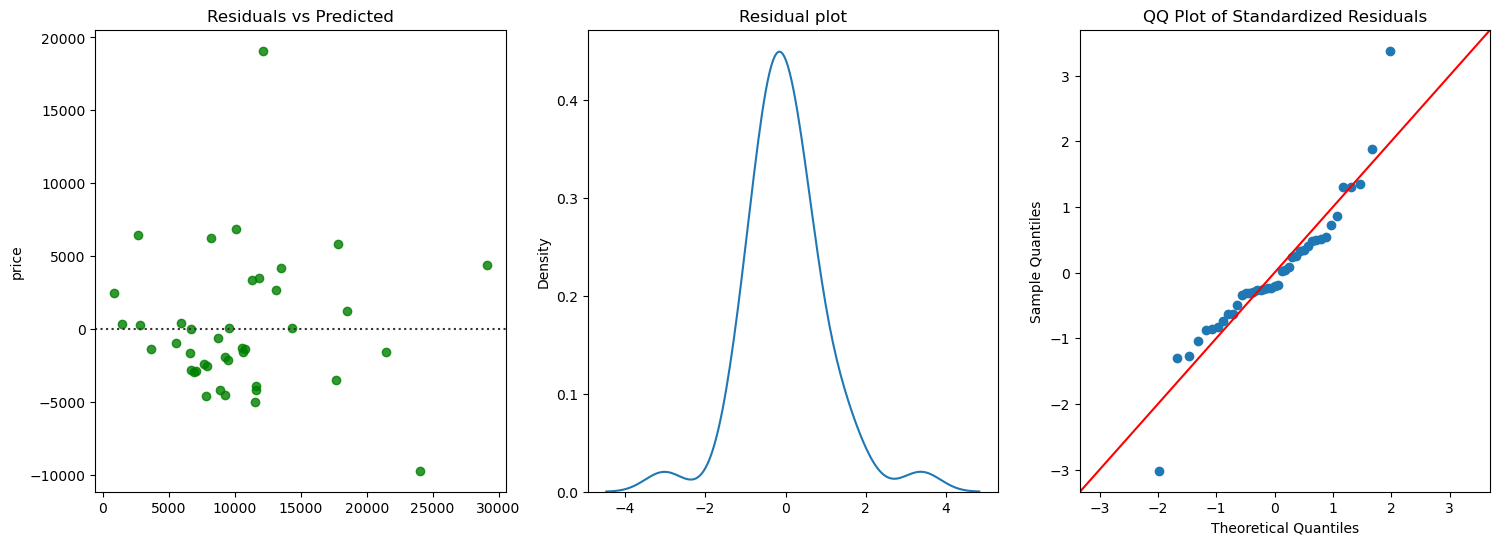

In [192]:
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
import statsmodels.api as sm

X_train=train_data.drop('price',"car_ID").to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price',"car_ID").to_pandas()
y_test=test_data['price'].to_pandas()

rkf=RepeatedKFold(n_splits=10,random_state=42)
cv_results = cross_validate(pipe, X_train,y_train, cv=rkf, scoring='r2')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(pipe, X_test, y_test)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3] = plt.subplots(ncols=3,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
plt.show()

### Model Performance Summary (Step 1)

#### Cross-Validation Results
- **Test Scores**: [0.89219672, 0.88416849, 0.82191252, 0.8520706, 0.70085257]
- **Training Scores**: [0.92104436, 0.92946774, 0.93581334, 0.93198012, 0.9445547]
- **Mean Test Score**: 0.8302401809384599
- **Standard Deviation of Test Scores**: 0.06933101436314953

#### Holdout Set Performance
- **Mean Absolute Error (MAE)**: 3239.0788831379577
- **R-squared (R²)**: 0.6968221192569758
- **Adjusted R-squared**: 0.5489304701140372

### Insights
- **Consistency**: Cross-validation test scores exhibit a reasonable level of consistency with a mean R² of 0.8302 and a standard deviation of 0.0693, indicating moderate variability in model performance across different folds.
- **Overfitting**: There is a noticeable gap between the training scores (average ~0.932) and test scores (average ~0.830), suggesting potential overfitting where the model performs significantly better on training data compared to unseen data.
- **Error Magnitude**: The MAE of 3239.08 on the holdout set indicates that the model's predictions deviate from the actual values by an average of approximately 3239 units, highlighting the prediction error magnitude.
- **Holdout Set R²**: An R² of 0.6968 on the holdout set shows the model explains approximately 69.68% of the variance in the holdout data, which signifies a reasonably good fit.
- **Adjusted R²**: The adjusted R² of 0.5489 on the holdout set indicates that when accounting for the number of predictors, the model explains around 54.89% of the variance, suggesting a decent explanatory power while considering model complexity.

# Conclusion : over fitting to train data and performing poor on test set (Holdout set)